### **Réseaux de neurones pour de la super-résolution**


L’objectif de ce projet est d’implémenter une méthode de **super-résolution pour des images Sentinel-2**.

Nous utilisons deux bandes :

- **B8 (10 m/pixel)** : bande haute résolution. Elle est downscalée pour créer des images basse résolution servant d’entrées au réseau. Les fichiers associés sont :
    - tensor_b8.pt
    - tensor_b8_ds.pt (versions PyTorch pour l'entrînement)
<br>

- **B8A (20 m/pixel)** : bande basse résolution réelle. Elle est upscalée pour être utilisée en inférence. Les fichiers associés sont :
    - tensor_b8a.pt
    - tensor_b8a_us.pt (versions PyTorch pour l'inférence)
      
Le réseau apprend à transformer des images LR → HR sur B8, puis cette compétence est appliquée pour super-résolutionner la bande B8A.

In [2]:
# Installation des dépendances 
%pip install torchmetrics
%pip install rasterio
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 11.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchmetrics] [torchmetrics]
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 11.1 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [rasterio]4/5 [rasterio]
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 38.9 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 62.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 86.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [3]:
# %run prepare_data.py 
# %run reconstruct_image.py 

### **Visualisation des données** 

Informations sur les tenseurs :
X_hr shape: torch.Size([29241, 64, 64])
X_lr shape: torch.Size([29241, 32, 32])


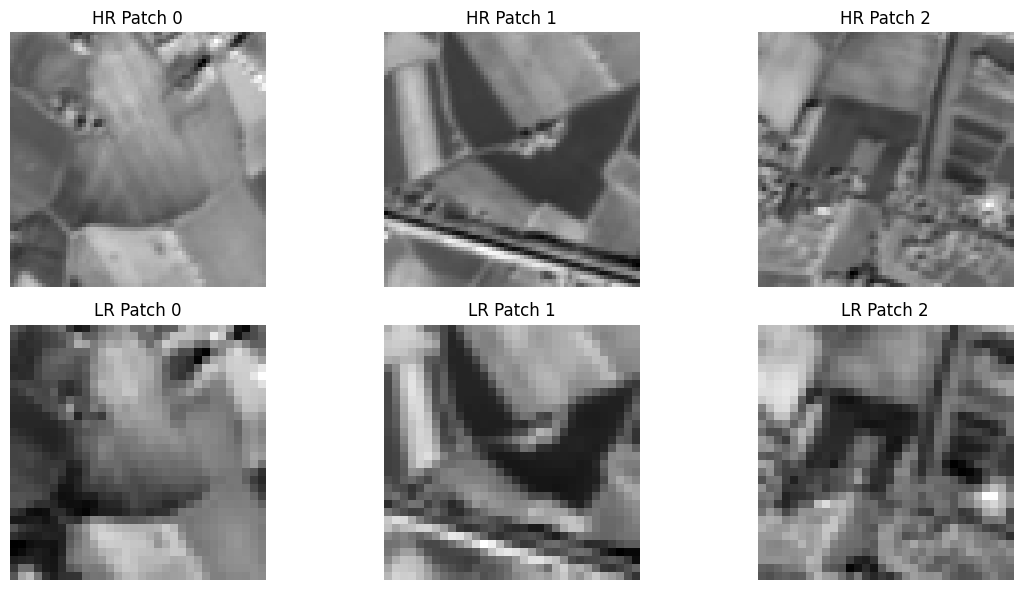

In [4]:
import torch
from matplotlib import pyplot as plt
import os

# Chemins vers les tenseurs
tensor_b8_path = "tensor_b8.pt"
tensor_b8_ds_path = "tensor_b8_ds.pt"

# Charger les tensors
X_hr = torch.load(tensor_b8_path)      # HR (High-Resolution) patches B8
X_lr = torch.load(tensor_b8_ds_path)   # LR (Low-Resolution) patches B8 downscaled

# Informations sur les tenseurs
print("Informations sur les tenseurs :")
print("X_hr shape:", X_hr.shape)
print("X_lr shape:", X_lr.shape)

# Visualiser les 3 premiers patchs
num_patches = 3
plt.figure(figsize=(12, 6))

for k in range(num_patches):
    img_hr = X_hr[k].numpy()
    img_lr = X_lr[k].numpy()

    # Affichage HR
    plt.subplot(2, num_patches, k+1)
    plt.imshow(img_hr, cmap='gray')
    plt.title(f"HR Patch {k}")
    plt.axis('off')

    # Affichage LR
    plt.subplot(2, num_patches, k+1+num_patches)
    plt.imshow(img_lr, cmap='gray')
    plt.title(f"LR Patch {k}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### **Préparation des données d'entraînement** 

In [5]:
import random
from torch.utils.data import DataLoader

# --- Copie des données pour ne pas écraser les originaux
X = X_lr.float()
Y = X_hr.float()

# --- Normalisation entre 0 et 1
X = X / X.max()
Y = Y / Y.max()

# --- Flip et rotations aléatoires
num_patches = X.shape[0]

for i in range(num_patches):
    # Flip horizontal
    if random.random() > 0.5:
        X[i] = torch.flip(X[i], [-1])
        Y[i] = torch.flip(Y[i], [-1])

    # Flip vertical
    if random.random() > 0.5:
        X[i] = torch.flip(X[i], [-2])
        Y[i] = torch.flip(Y[i], [-2])

    # Rotation 0°, 90°, 180°, 270°
    k = random.randint(0, 3)
    X[i] = torch.rot90(X[i], k, [0,1])
    Y[i] = torch.rot90(Y[i], k, [0,1])


# Ratios
train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

# Création d'un dataset
dataset = torch.utils.data.dataset.TensorDataset(X.unsqueeze(1), Y.unsqueeze(1))

# Séparation des données
num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
valid_size = int(valid_ratio * num_samples)
test_size = num_samples - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.dataset.random_split(
    dataset, [train_ratio, valid_ratio, test_ratio]
)

# Création de Data-Loaders pour entraîner le réseau
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Taille des données

print("Nombre d’échantillons :", num_samples,'\n')
print("Taille du dataset d’entraînement :", len(train_dataset))
print("Taille du dataset de validation :", len(valid_dataset))
print("Taille du dataset de test :", len(test_dataset),'\n')
print("Exemple d'échantillon : ", dataset[0][0].shape, ",", dataset[0][1].shape)

Nombre d’échantillons : 29241 

Taille du dataset d’entraînement : 20469
Taille du dataset de validation : 2924
Taille du dataset de test : 5848 

Exemple d'échantillon :  torch.Size([1, 32, 32]) , torch.Size([1, 64, 64])


### **Baseline bicubique : mesures PSNR/SSIM**

In [7]:
import torch.nn.functional as F
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# Sélectionne le GPU si disponible, sinon CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device is :",device)

# Upsampling bicubique ×2 de l'image basse résolution X
X_up = F.interpolate(X.unsqueeze(1), scale_factor=2, mode="bicubic", align_corners=False)

# On s'assure que les valeurs restent dans l'intervalle [0, 1]
X_up = X_up.clamp(0.0, 1.0)

# Déclaration des métriques PSNR et SSIM
psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Calcul et affichage du PSNR et du SSIM entre l'image upscalée (bicubic)
print("Bicubic PSNR:", psnr(X_up, Y.unsqueeze(1)).item())
print("Bicubic SSIM:", ssim(X_up, Y.unsqueeze(1)).item())  # à utiliser uniquement sur GPU

device is : cuda
Bicubic PSNR: 26.606388092041016
Bicubic SSIM: 0.919247567653656


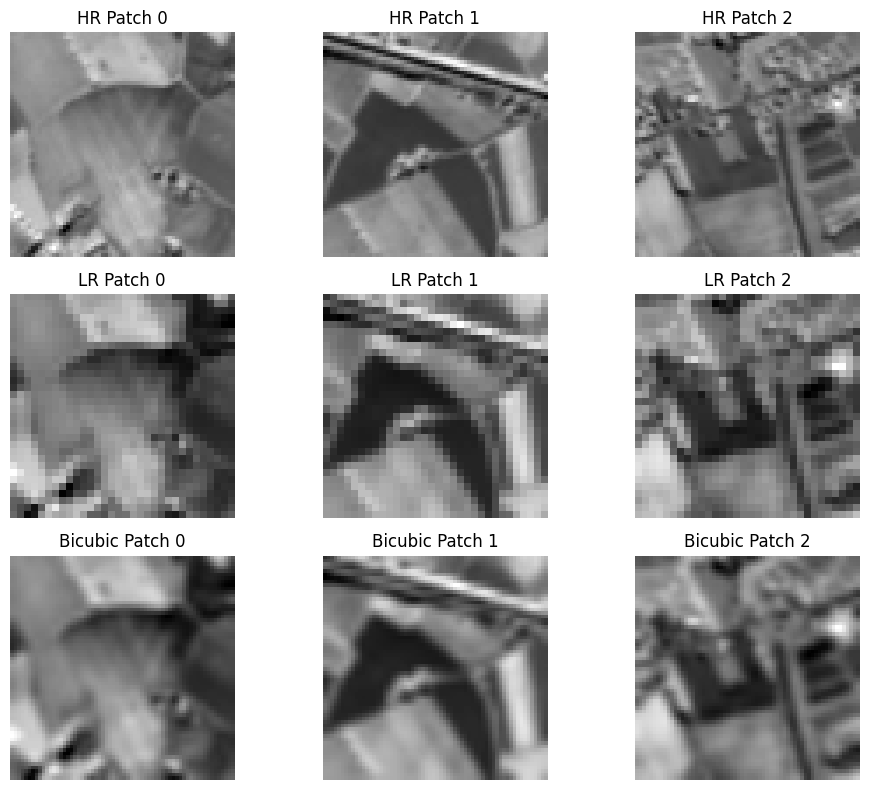

In [8]:
# Visualiser les 3 premiers patchs: HR, LR, UP
num_patches = 3
rows = 3
cols = num_patches

plt.figure(figsize=(10, 8))
for k in range(num_patches):
    img_hr = Y[k].numpy()                       # (64, 64)
    img_lr = X[k].numpy()                       # (32, 32)
    img_up = X_up[k].squeeze().numpy()          # (64, 64)

    # ----- HR (ligne 1) -----
    plt.subplot(rows, cols, 1 + k)
    plt.imshow(img_hr, cmap='gray')
    plt.title(f"HR Patch {k}")
    plt.axis('off')

    # ----- LR (ligne 2) -----
    plt.subplot(rows, cols, cols + 1 + k)       
    plt.imshow(img_lr, cmap='gray')
    plt.title(f"LR Patch {k}")
    plt.axis('off')

    # ----- UP (ligne 3) -----
    plt.subplot(rows, cols, 2*cols + 1 + k)    
    plt.imshow(img_up, cmap='gray')
    plt.title(f"Bicubic Patch {k}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### **Implémentation et entraînement du modèle**

In [9]:
import torch.nn as nn
import torch

"""
# test: conv relu conv relu upsample
class Premier_modele(nn.Module):
    def __init__(self):
        super().__init__()
        # Extraction de features de taille 32x32
        self.feat = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        # Upsampling x2 : 32x32 -> 64x64
        self.up = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1,
        )

    def forward(self, x):
        x = self.feat(x)         
        x = self.up(x)           
        x = torch.sigmoid(x)     # on force dans [0,1]
        return x
"""

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
    def forward(self, x):
        return x + self.block(x)


class ESPCN(nn.Module):
    def __init__(self, scale_factor=2, in_channels=1):
        super().__init__()

        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, 5, padding=2),
            nn.PReLU()
        )

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(4)]
        )

        self.post_conv = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.PReLU(),
            nn.Conv2d(32, scale_factor**2, 3, padding=1)
        )

        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.pre_conv(x)
        x = self.res_blocks(x)
        x = self.post_conv(x)
        x = self.pixel_shuffle(x)
        return x


In [10]:
import torch.optim as optim
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Modèle Super-Résolution
model = ESPCN(scale_factor=2).to(device)

# --- Loss
criterion = nn.L1Loss()

# --- Learning rate
learning_rate = 1e-3

# --- Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10

train_losses = []
valid_losses = []
train_psnr = []
valid_psnr = []

best_valid_loss = float("inf")


# -----------------------------
#   Fonction PSNR
# ----------------------------- --- PAS COMPRIS ICI --- on def fct deja importé
def compute_psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))


# -----------------------------
#        TRAINING LOOP
# -----------------------------
for epoch in range(num_epochs):

    # ------- TRAIN -------
    model.train()
    total_train_loss = 0
    total_train_psnr = 0

    for X_lr, Y_hr in train_loader:
        X_lr = X_lr.to(device)     # Low-res 32×32
        Y_hr = Y_hr.to(device)     # High-res 64×64

        optimizer.zero_grad()
        preds = model(X_lr)

        loss = criterion(preds, Y_hr)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * X_lr.size(0)
        #total_train_psnr += compute_psnr(preds.detach(), Y_hr).item() ### --- PAS COMPRIS ICI --- on def fct deja importé
        total_train_psnr += psnr(preds.detach(), Y_hr).item()
        
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    avg_train_psnr = total_train_psnr / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)


    # ------- VALID -------
    model.eval()
    total_valid_loss = 0
    total_valid_psnr = 0

    with torch.no_grad():
        for X_lr, Y_hr in valid_loader:
            X_lr = X_lr.to(device)
            Y_hr = Y_hr.to(device)

            preds = model(X_lr)
            loss = criterion(preds, Y_hr)

            total_valid_loss += loss.item() * X_lr.size(0)
            #total_valid_psnr += compute_psnr(preds, Y_hr).item() ### --- PAS COMPRIS ICI --- on def fct deja importé
            total_valid_psnr += psnr(preds, Y_hr).item() 
            
    avg_valid_loss = total_valid_loss / len(valid_loader.dataset)
    avg_valid_psnr = total_valid_psnr / len(valid_loader.dataset)
    valid_losses.append(avg_valid_loss)
    valid_psnr.append(avg_valid_psnr)


    # Print
    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"- Train Loss: {avg_train_loss:.6f} | PSNR: {avg_train_psnr:.2f} dB "
        f"- Valid Loss: {avg_valid_loss:.6f} | PSNR: {avg_valid_psnr:.2f} dB"
    )

    # Save best model
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), "best_model_sr.pt")
        print("Best model saved")

Using device: cuda
Epoch [1/10] - Train Loss: 0.012088 | PSNR: 1.15 dB - Valid Loss: 0.006681 | PSNR: 1.25 dB
Best model saved
Epoch [2/10] - Train Loss: 0.006947 | PSNR: 1.24 dB - Valid Loss: 0.006621 | PSNR: 1.26 dB
Best model saved
Epoch [3/10] - Train Loss: 0.006615 | PSNR: 1.25 dB - Valid Loss: 0.006284 | PSNR: 1.27 dB
Best model saved
Epoch [4/10] - Train Loss: 0.006420 | PSNR: 1.26 dB - Valid Loss: 0.006895 | PSNR: 1.26 dB
Epoch [5/10] - Train Loss: 0.006264 | PSNR: 1.26 dB - Valid Loss: 0.006316 | PSNR: 1.27 dB
Epoch [6/10] - Train Loss: 0.006165 | PSNR: 1.27 dB - Valid Loss: 0.006101 | PSNR: 1.28 dB
Best model saved
Epoch [7/10] - Train Loss: 0.006111 | PSNR: 1.27 dB - Valid Loss: 0.006359 | PSNR: 1.27 dB
Epoch [8/10] - Train Loss: 0.006046 | PSNR: 1.27 dB - Valid Loss: 0.006222 | PSNR: 1.28 dB
Epoch [9/10] - Train Loss: 0.006002 | PSNR: 1.27 dB - Valid Loss: 0.005864 | PSNR: 1.28 dB
Best model saved
Epoch [10/10] - Train Loss: 0.005939 | PSNR: 1.27 dB - Valid Loss: 0.005933 |

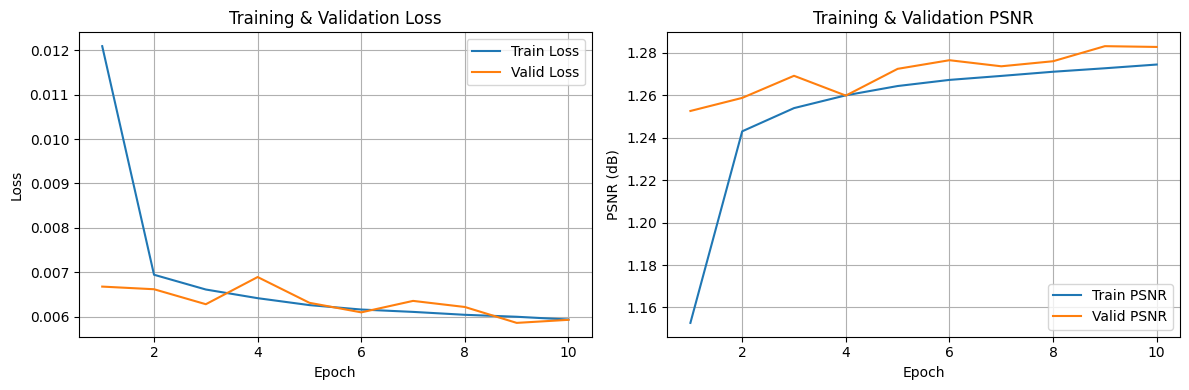

In [11]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# --- Subplot 1 : Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Subplot 2 : PSNR ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_psnr, label='Train PSNR')
plt.plot(epochs, valid_psnr, label='Valid PSNR')
plt.title("Training & Validation PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Prédictions et Évaluation**

In [12]:
model = model.to(device)
model.eval()

psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# listes pour stocker les prédictions et ground truths
all_pred = []
all_gt   = [] 

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        
        X_batch = X_batch.float()
        Y_batch = Y_batch.float()

        # sécurité mais pas sur d'en avoir besoin
        X_batch = X_batch.clamp(0.0, 1.0).to(device)
        Y_batch = Y_batch.clamp(0.0, 1.0).to(device)

        # Prédiction modèle (32→64)
        Y_pred = model(X_batch).clamp(0.0, 1.0)

        all_pred.append(Y_pred.cpu())
        all_gt.append(Y_batch.cpu())

# Concaténer toutes les prédictions / ground truths
Y_sr = torch.cat(all_pred, dim=0)   # (N_test,1,64,64)
Y_hr = torch.cat(all_gt, dim=0)     # (N_test,1,64,64)

# Calcul PSNR / SSIM sur le test set
model_psnr = psnr_metric(Y_sr.to(device), Y_hr.to(device)).item()
model_ssim = ssim_metric(Y_sr.to(device), Y_hr.to(device)).item() #gpu uniquement

print(f"Model TEST PSNR: {model_psnr:.2f} dB")
print(f"Model TEST SSIM: {model_ssim:.4f}") 

Model TEST PSNR: 40.73 dB
Model TEST SSIM: 0.9669


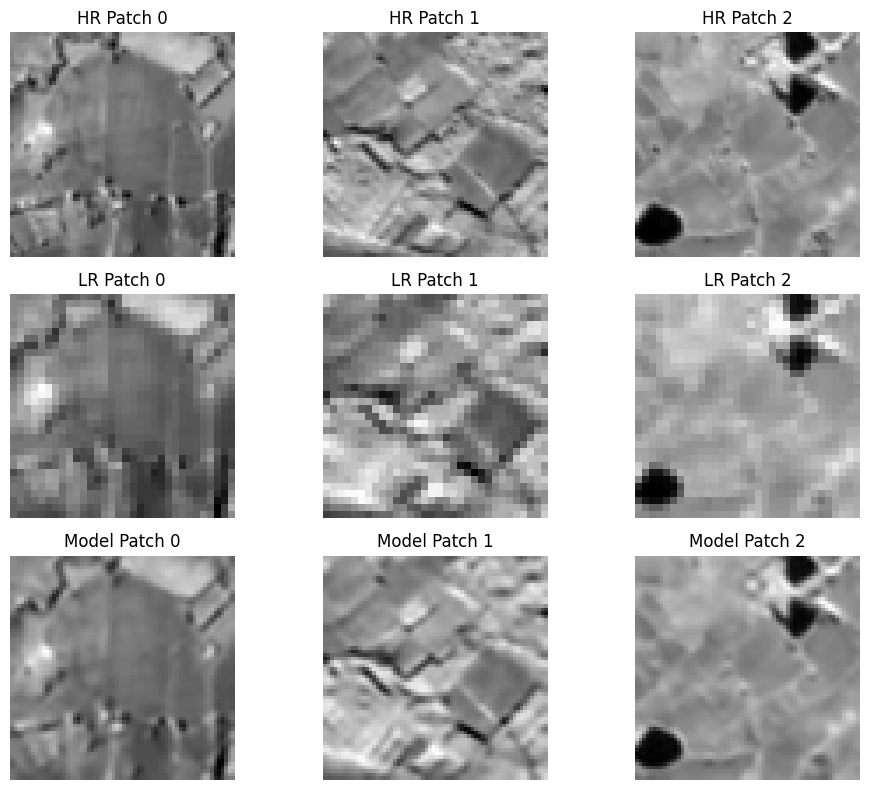

In [13]:
# Récupérer un batch pour la visualisation
X_vis, Y_vis = next(iter(test_loader))

X_vis = X_vis.float()
Y_vis = Y_vis.float()

# sécurité mais pas sur d'en avoir besoin
X_vis = X_vis.clamp(0.0, 1.0).to(device)
Y_vis = Y_vis.clamp(0.0, 1.0).to(device)

with torch.no_grad():
    Y_sr_vis = model(X_vis).clamp(0.0, 1.0)

# Revenir sur CPU pour matplotlib
X_vis_cpu   = X_vis.cpu()
Y_vis_cpu   = Y_vis.cpu()
Y_sr_vis_cpu = Y_sr_vis.cpu()

num_patches = 3
rows = 3
cols = num_patches

plt.figure(figsize=(10, 8))

for k in range(num_patches):
    img_hr = Y_vis_cpu[k].squeeze().numpy()      # (64,64)
    img_lr = X_vis_cpu[k].squeeze().numpy()      # (32,32)
    img_sr = Y_sr_vis_cpu[k].squeeze().numpy()   # (64,64)

    # ----- HR (ligne 1) -----
    plt.subplot(rows, cols, 1 + k)
    plt.imshow(img_hr, cmap='gray')
    plt.title(f"HR Patch {k}")
    plt.axis('off')

    # ----- LR (ligne 2) -----
    plt.subplot(rows, cols, cols + 1 + k)
    plt.imshow(img_lr, cmap='gray')
    plt.title(f"LR Patch {k}")
    plt.axis('off')

    # ----- SR modèle (ligne 3) -----
    plt.subplot(rows, cols, 2*cols + 1 + k)
    plt.imshow(img_sr, cmap='gray')
    plt.title(f"Model Patch {k}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### **Reconstruction et Comparaison** Bande B8A

In [14]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device, "\n")

model = model.to(device)
model.eval()

# 1) Charger TOUS les patchs B8A basse résolution
b8a_lr = torch.load("tensor_b8a.pt")   
print("B8A LR shape (avant reshape):", b8a_lr.shape)

# 2) Mise en forme : (N,1,H,W)
if b8a_lr.dim() == 3:
    b8a_lr = b8a_lr.unsqueeze(1)          # (N,1,H,W)

b8a_lr = b8a_lr.float()

# Normalisation Sentinel-2 si les valeurs sont dans 0..10000
if b8a_lr.max() > 1.5:
    b8a_lr = b8a_lr / 10000.0

b8a_lr = b8a_lr.clamp(0.0, 1.0)
print("B8A LR shape (après reshape):", b8a_lr.shape)

# Créer un tenseur bicubique 
bicubic_patches = F.interpolate(b8a_lr, scale_factor=2, mode='bicubic', align_corners=False)
bicubic_patches = bicubic_patches.clamp(0.0, 1.0)
print("Bicubic patches shape:", bicubic_patches.shape)

# 3) DataLoader pour passer tous les patchs dans le modèle
batch_size = 256
dl = DataLoader(TensorDataset(b8a_lr), batch_size=batch_size, shuffle=False)

sr_patches = []

with torch.no_grad():
    for (xb,) in dl:                  # ici, un seul tensor par batch
        xb = xb.to(device)            # (B,1,H,W)
        yb = model(xb)                # (B,1,64,64) si ton modèle fait x2
        yb = yb.clamp(0.0, 1.0)
        sr_patches.append(yb.cpu())

sr_patches = torch.cat(sr_patches, dim=0)          # (N,1,64,64)
print("SR patches shape:", sr_patches.shape)

# 4) Revenir à une échelle type Sentinel-2 (int16 0..10000) pour le GeoTIFF
sr_rescaled = (sr_patches * 10000.0).round().short().squeeze(1)      # (N,64,64)
bicubic_rescaled = (bicubic_patches * 10000.0).round().short().squeeze(1)  # (N,64,64)

print("SR patches 2D shape:", sr_rescaled.shape)
print("Bicubic patches 2D shape:", bicubic_rescaled.shape, "\n")

# 5) Sauvegarde pour reconstruct_image.py
torch.save(sr_rescaled, "tensor_b8a_us.pt")
torch.save(bicubic_rescaled, "tensor_b8a_bicubic.pt")
print("✅ Patches SR B8A sauvegardés dans tensor_b8a_us.pt")
print("✅ Patches Bicubic sauvegardés dans tensor_b8a_bicubic.pt")


Device: cuda 

B8A LR shape (avant reshape): torch.Size([29241, 32, 32])
B8A LR shape (après reshape): torch.Size([29241, 1, 32, 32])
Bicubic patches shape: torch.Size([29241, 1, 64, 64])
SR patches shape: torch.Size([29241, 1, 64, 64])
SR patches 2D shape: torch.Size([29241, 64, 64])
Bicubic patches 2D shape: torch.Size([29241, 64, 64]) 

✅ Patches SR B8A sauvegardés dans tensor_b8a_us.pt
✅ Patches Bicubic sauvegardés dans tensor_b8a_bicubic.pt


In [15]:
!python3 reconstruct_image_v2.py tensor_b8a_us.pt output_sr.tif
print("\n")
!python3 reconstruct_image_v2.py tensor_b8a_bicubic.pt output_bicubic.tif

Tensor loaded: torch.Size([29241, 64, 64])
Expected patches: 29241
Tensor patches   : 29241
Last patch index: 29240
✅ Image reconstructed and saved to: output_sr.tif


Tensor loaded: torch.Size([29241, 64, 64])
Expected patches: 29241
Tensor patches   : 29241
Last patch index: 29240
✅ Image reconstructed and saved to: output_bicubic.tif


HR (reference): shape=(10980, 10980), min=0, max=10915
Bicubic: shape=(10944, 10944), min=0, max=10000
SR (model): shape=(10944, 10944), min=0, max=10000


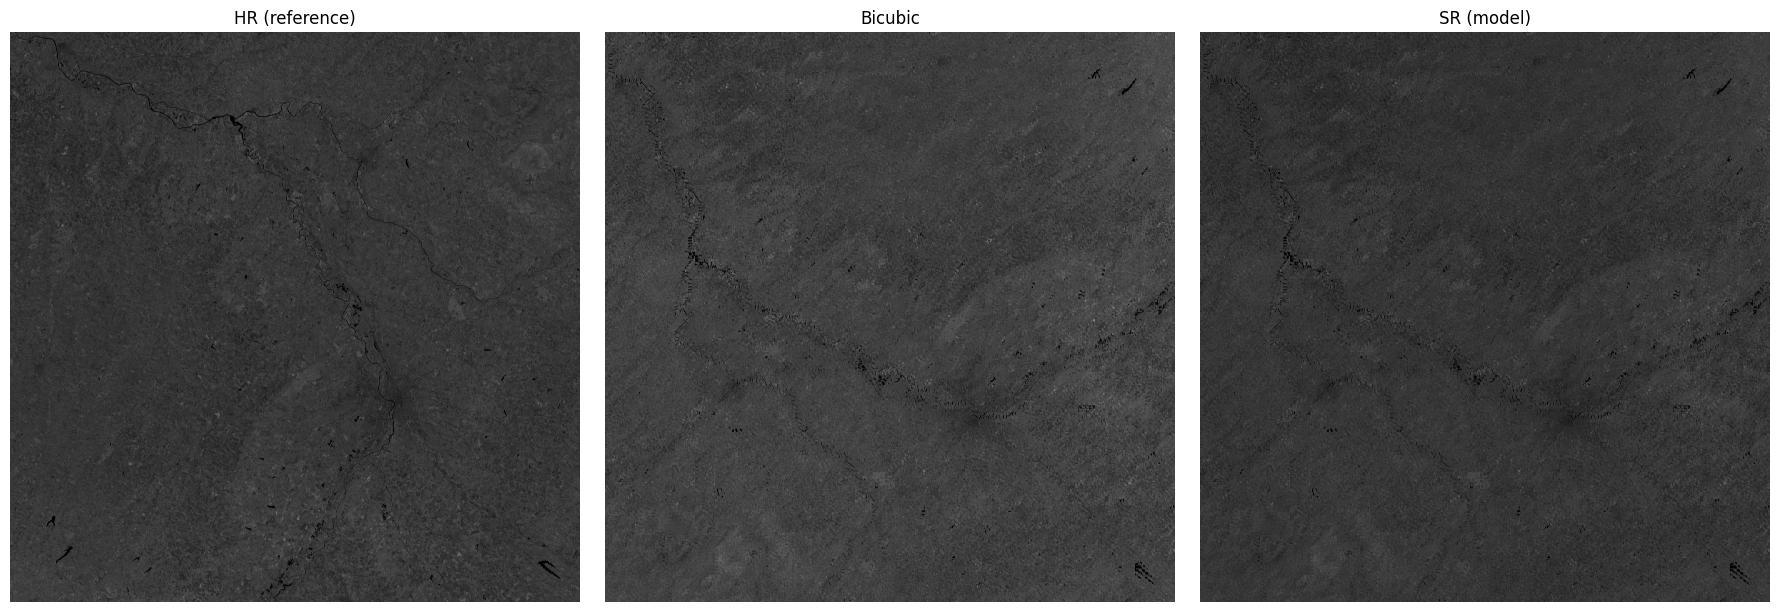

In [16]:
import rasterio
import matplotlib.pyplot as plt

# Chemins des trois images
tif_paths = {
    "HR (reference)": "SENTINEL2X_20181015-000000-000_L3A_T31TCJ_D_V1-1_FRC_B8.tif",  # haute résolution
    "Bicubic": "output_bicubic.tif",
    "SR (model)": "output_sr.tif"
}

# Créer la figure
plt.figure(figsize=(18, 6))

for i, (title, path) in enumerate(tif_paths.items(), 1):
    # Lire l'image
    with rasterio.open(path) as src:
        img = src.read(1)  # lire la première bande
    
    # Affichage
    plt.subplot(1, 3, i)
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    print(f"{title}: shape={img.shape}, min={img.min()}, max={img.max()}")

plt.tight_layout()
plt.show()


HR (reference): zoom shape=(500, 500), min=50, max=5682
SR (model): zoom shape=(500, 500), min=0, max=4601
Bicubic: zoom shape=(500, 500), min=0, max=4985


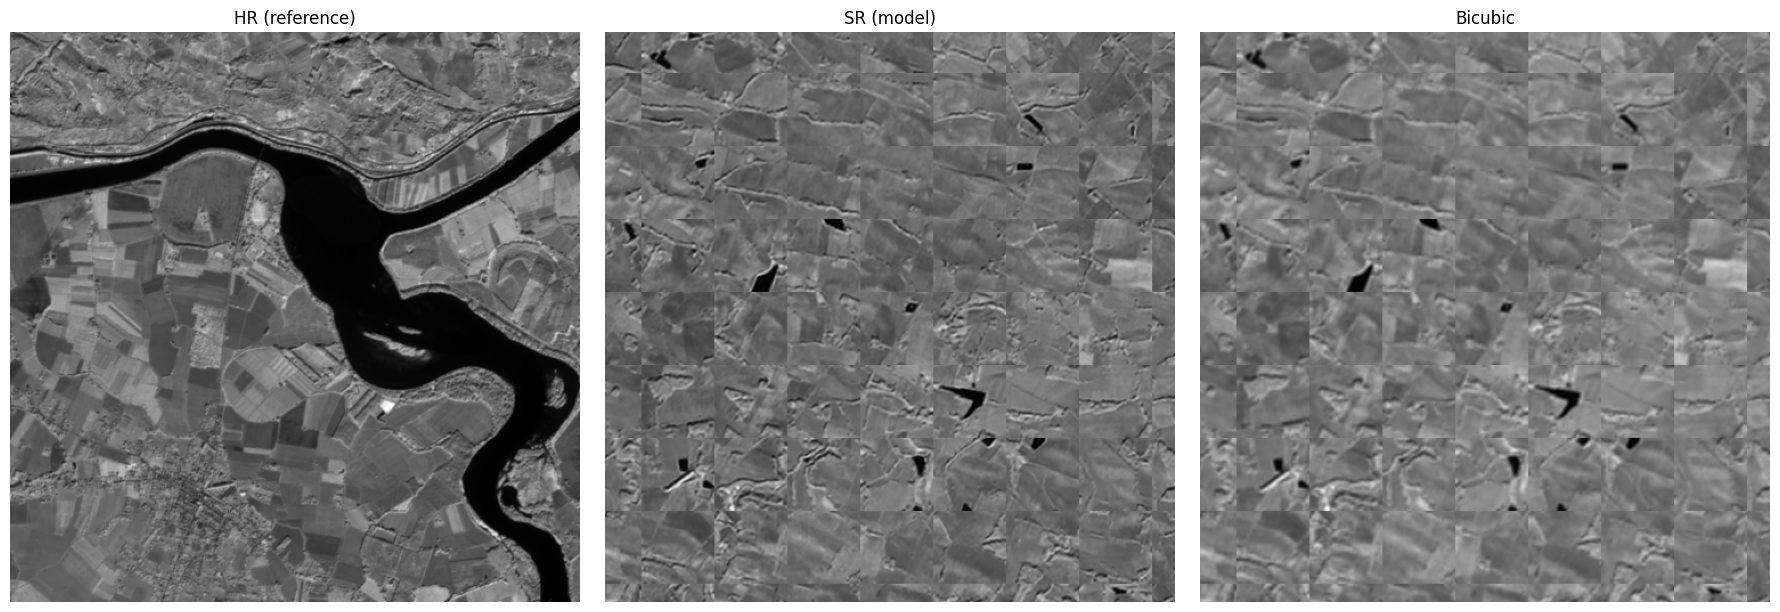

In [17]:
import rasterio
import matplotlib.pyplot as plt

# Chemins des trois images
tif_paths = {
    "HR (reference)": "SENTINEL2X_20181015-000000-000_L3A_T31TCJ_D_V1-1_FRC_B8.tif",
    "SR (model)": "output_sr.tif",
    "Bicubic": "output_bicubic.tif"
}

# Zone de zoom (à adapter selon ton intérêt)
y1, y2 = 1500, 2000
x1, x2 = 4000, 4500

plt.figure(figsize=(18, 6))

for i, (title, path) in enumerate(tif_paths.items(), 1):
    # Charger l'image
    with rasterio.open(path) as src:
        img = src.read(1)
    
    # Extraire la zone de zoom
    zoom = img[y1:y2, x1:x2]

    # Affichage
    plt.subplot(1, 3, i)
    plt.imshow(zoom, cmap="gray")
    plt.title(title)
    plt.axis("off")
    print(f"{title}: zoom shape={zoom.shape}, min={zoom.min()}, max={zoom.max()}")

plt.tight_layout()
plt.show()


In [19]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# --- CALCUL PSNR / SSIM PATCH-LEVEL

print("\n=== Calcul PSNR / SSIM patch-level ===")

# Référence HR patchée (high-resolution GT)
b8_hr = torch.load("tensor_b8.pt")      # (N,H,W) ou (N,1,H,W)

if b8_hr.dim() == 3:
    b8_hr = b8_hr.unsqueeze(1)

b8_hr = b8_hr.float()

# Normalisation Sentinel-2 si nécessaire
if b8_hr.max() > 1.5:
    b8_hr = b8_hr / 10000.0

b8_hr = b8_hr.clamp(0.0, 1.0)

print("HR patches shape:", b8_hr.shape)
print("LR bicubic shape:", bicubic_patches.shape)
print("SR model shape  :", sr_patches.shape)

# Torchmetrics init
data_range = 1.0
psnr_metric = PeakSignalNoiseRatio(data_range=data_range).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=data_range).to(device)

# Tout envoyer sur bon device
b8_hr = b8_hr.to(device)
bicubic_patches = bicubic_patches.to(device)
sr_patches = sr_patches.to(device)

# PSNR / SSIM SR
psnr_sr = psnr_metric(sr_patches, b8_hr).item()
ssim_sr = ssim_metric(sr_patches, b8_hr).item()

# PSNR / SSIM Bicubic
psnr_bic = psnr_metric(bicubic_patches, b8_hr).item()
ssim_bic = ssim_metric(bicubic_patches, b8_hr).item()

print("\n===== RESULTATS =====")
print(f"PSNR (SR model)    : {psnr_sr:.4f} dB")
print(f"SSIM (SR model)    : {ssim_sr:.4f}")
print(f"PSNR (Bicubic)     : {psnr_bic:.4f} dB")
print(f"SSIM (Bicubic)     : {ssim_bic:.4f}")
print("=====================\n")



=== Calcul PSNR / SSIM patch-level ===
HR patches shape: torch.Size([29241, 1, 64, 64])
LR bicubic shape: torch.Size([29241, 1, 64, 64])
SR model shape  : torch.Size([29241, 1, 64, 64])

===== RESULTATS =====
PSNR (SR model)    : 30.5794 dB
SSIM (SR model)    : 0.9432
PSNR (Bicubic)     : 32.6064 dB
SSIM (Bicubic)     : 0.9206



### **Construction** Superésolution (64 à 128?)

peut etre comparer les images finales (psnr/ssim) 
un peu perdu sur la finalité et les métriques en vrai
revoir et justifier le choix du réseau